In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

In [5]:
df = pd.read_csv("tip.csv")

In [7]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [17]:
print("Dataset Shape:", df.shape)
print()
print("Dataset Info:")
print(df.info())
print()
print("Summary Statistics:")
print(df.describe())

Dataset Shape: (244, 7)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB
None

Summary Statistics:
       total_bill         tip        size
count  244.000000  244.000000  244.000000
mean    19.785943    2.998279    2.569672
std      8.902412    1.383638    0.951100
min      3.070000    1.000000    1.000000
25%     13.347500    2.000000    2.000000
50%     17.795000    2.900000    2.000000
75%     24.127500    3.562500    3.000000
max     50.810000   10.000000    6.000000


## Data Description

Here's a description of each column in the dataset:

total_bill: The total bill amount, including the cost of food and drinks.

tip: The tip amount given by the customer.

sex: The gender of the customer (e.g., Male or Female).

smoker: Whether the customer is a smoker or not (e.g., Yes or No).

day: The day of the week when the transaction occurred (e.g., Sun, Sat, Thu, etc.).

time: The time of day when the transaction occurred, typically categorized as Lunch or Dinner.

size: The size of the party or group of customers.

## Data Visualisation and Linearity Analysis

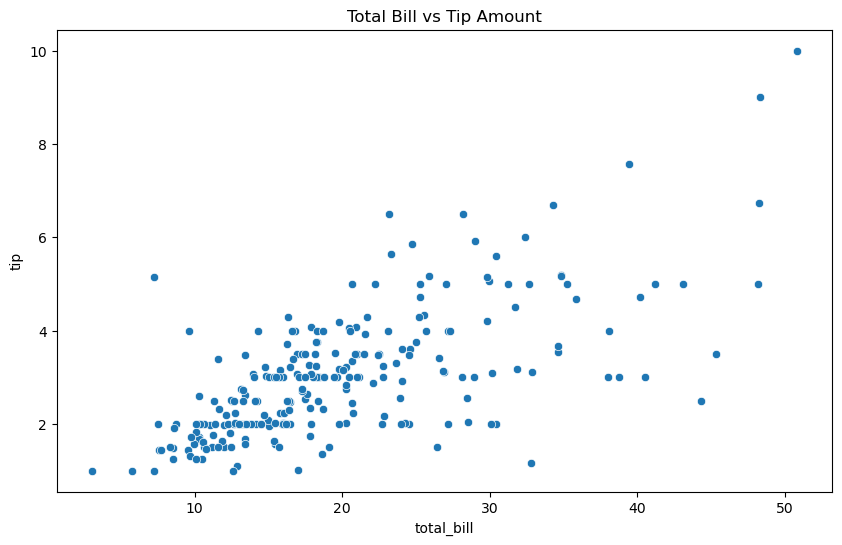

In [27]:
# Scatter Plot

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='total_bill', y='tip')
plt.title('Total Bill vs Tip Amount')
plt.show()

            total_bill       tip      size
total_bill    1.000000  0.989443  0.987291
tip           0.989443  1.000000  0.999883
size          0.987291  0.999883  1.000000



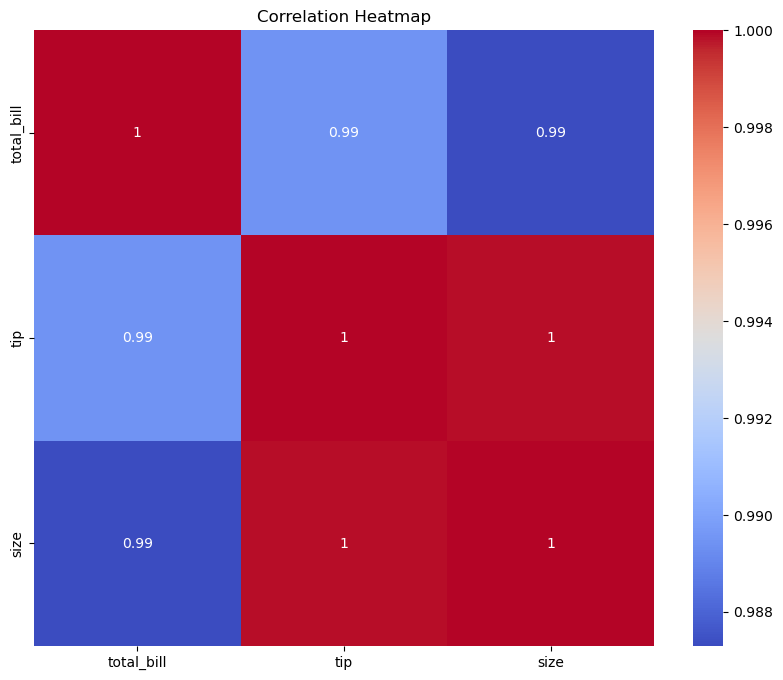

In [33]:
correlation_matrix = df.describe().corr()
print(correlation_matrix)
print()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

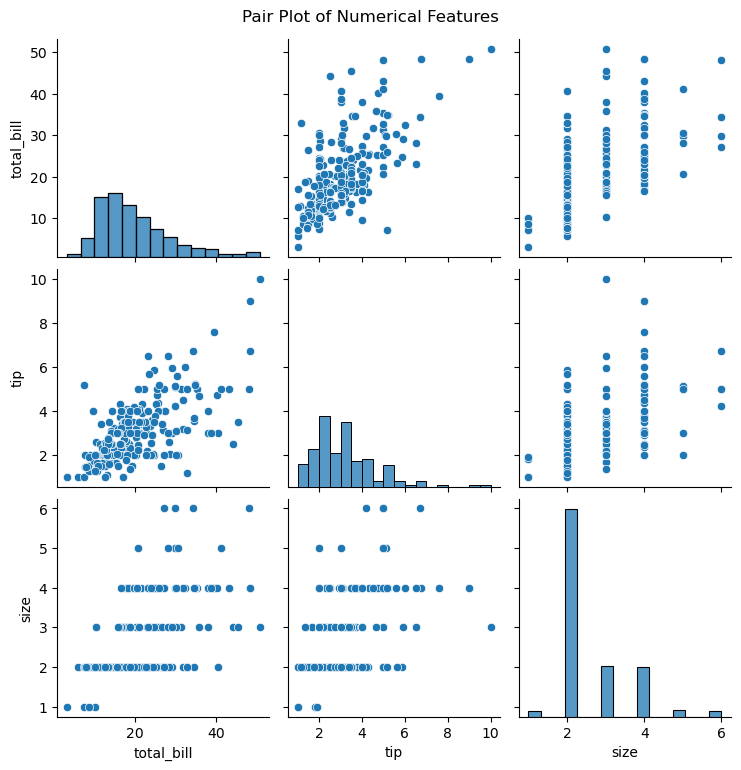

In [39]:
# Pair Plot

sns.pairplot(df, vars=['total_bill', 'tip', 'size'])
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()

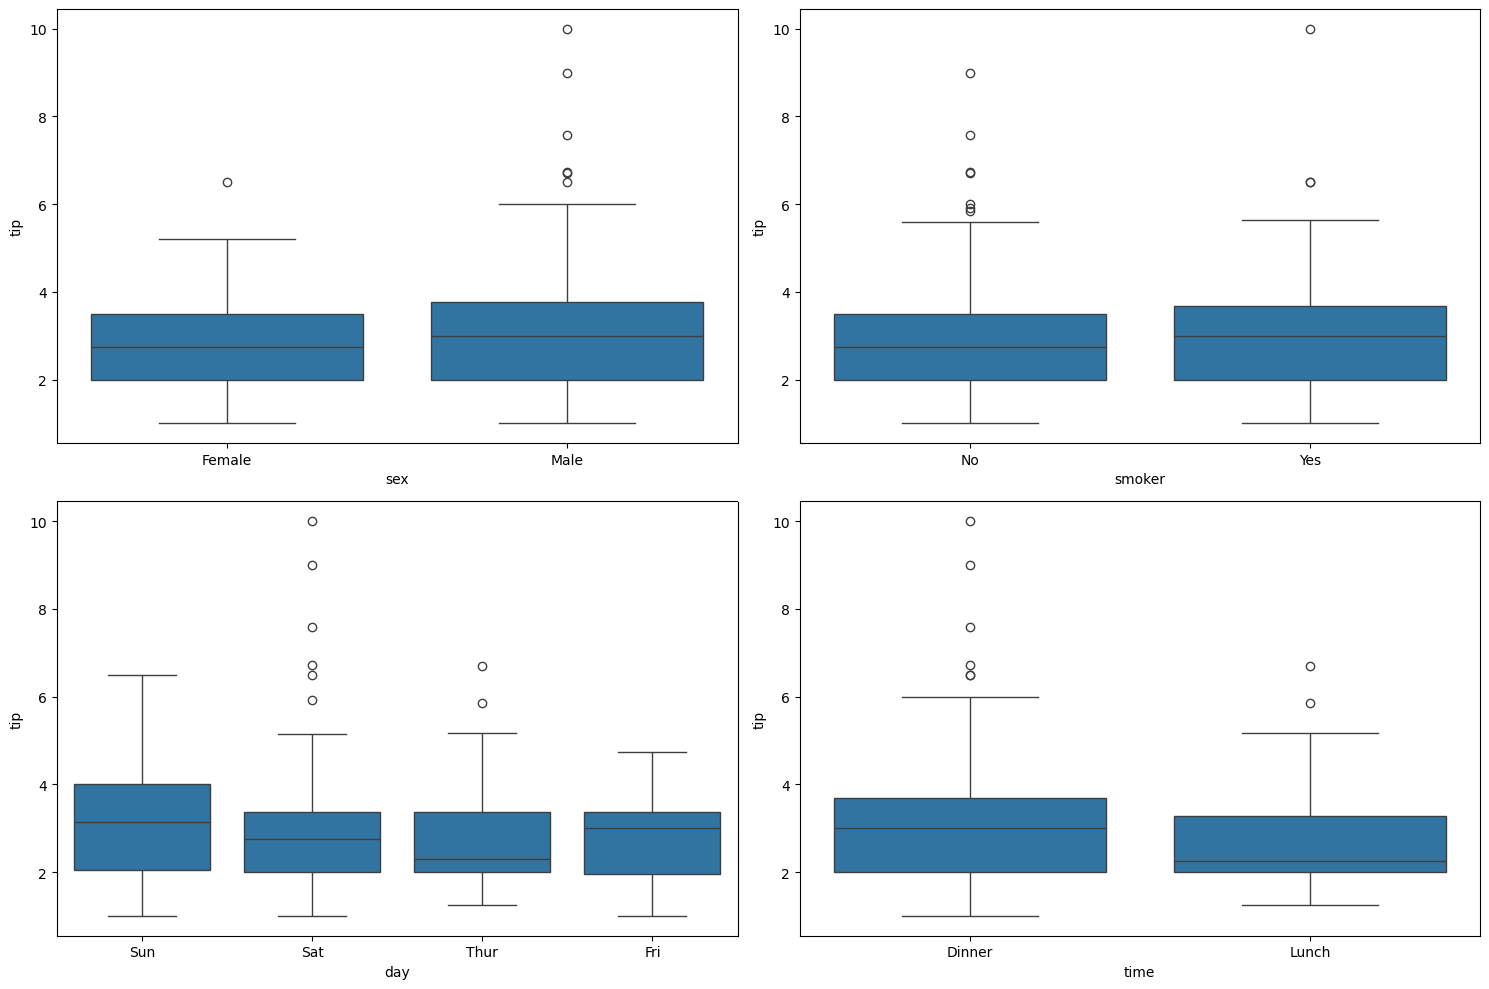

In [41]:
# BoxPlot for categorical features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(data=df, x='sex', y='tip', ax=axes[0, 0])
sns.boxplot(data=df, x='smoker', y='tip', ax=axes[0, 1])
sns.boxplot(data=df, x='day', y='tip', ax=axes[1, 0])
sns.boxplot(data=df, x='time', y='tip', ax=axes[1, 1])
plt.tight_layout()
plt.show()

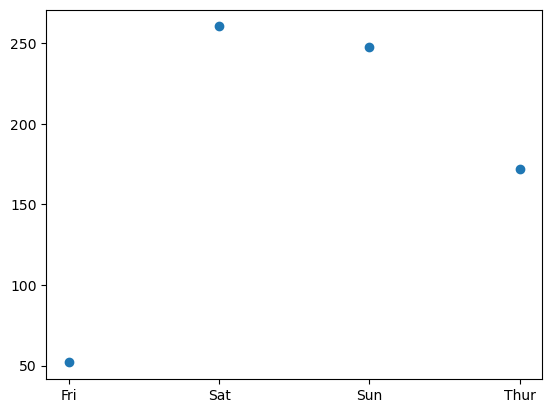

In [114]:
# Plotting the sum of tip versus day of the week
df.groupby(by = "day")
plt.scatter(df.groupby(by = "day")["tip"].sum().index, df.groupby(by = "day")["tip"].sum().values)

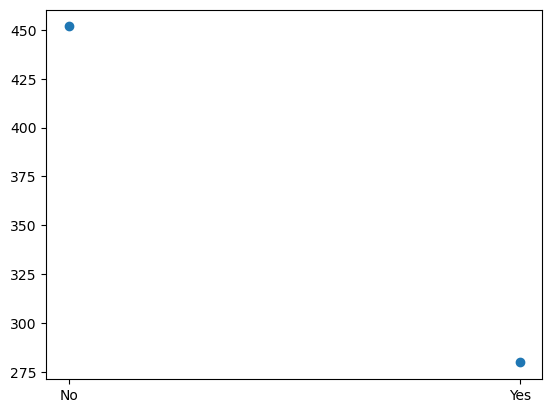

In [122]:
# Plotting the sum of tip versus smoker and non smoker
df.groupby(by = "day")
plt.scatter(df.groupby(by = "smoker")["tip"].sum().index, df.groupby(by = "smoker")["tip"].sum().values)

## Data PreProcessing

In [57]:
# Splitting the dataset 
X = df.drop('tip', axis=1)
y = df['tip']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Identify numeric and categorical columns
numeric_features = ['total_bill', 'size']
categorical_features = ['sex', 'smoker', 'day', 'time']

In [55]:
# Create preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

In [59]:
# Creating the function to evaluate the models

def evaluate_model(model, name):
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Fit and predict
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    
    print(f"\n{name} Results:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Cross-validation R2 Scores: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    return pipeline, rmse, r2

## Creating and Evaluating Models

In [66]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=0.1),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR(kernel='rbf'),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

In [68]:
results = {}
for name, model in models.items():
    pipeline, rmse, r2 = evaluate_model(model, name)
    results[name] = {'RMSE': rmse, 'R2': r2}


Linear Regression Results:
RMSE: 0.8387
R2 Score: 0.4373
Cross-validation R2 Scores: 0.4215 (+/- 0.2706)

Ridge Regression Results:
RMSE: 0.8385
R2 Score: 0.4375
Cross-validation R2 Scores: 0.4217 (+/- 0.2702)

Lasso Regression Results:
RMSE: 0.7824
R2 Score: 0.5102
Cross-validation R2 Scores: 0.4573 (+/- 0.2166)

Decision Tree Results:
RMSE: 1.1204
R2 Score: -0.0042
Cross-validation R2 Scores: 0.1043 (+/- 0.3286)

Random Forest Results:
RMSE: 0.9582
R2 Score: 0.2654
Cross-validation R2 Scores: 0.4015 (+/- 0.2425)

SVR Results:
RMSE: 0.8423
R2 Score: 0.4324
Cross-validation R2 Scores: 0.4049 (+/- 0.2603)

KNN Results:
RMSE: 0.8971
R2 Score: 0.3561
Cross-validation R2 Scores: 0.3378 (+/- 0.1663)


### Thus, we can see that the linear models perform good and in those too, the SVR is performing the best with and R2 Score of 0.4324

## Feature importance analysis using random forests

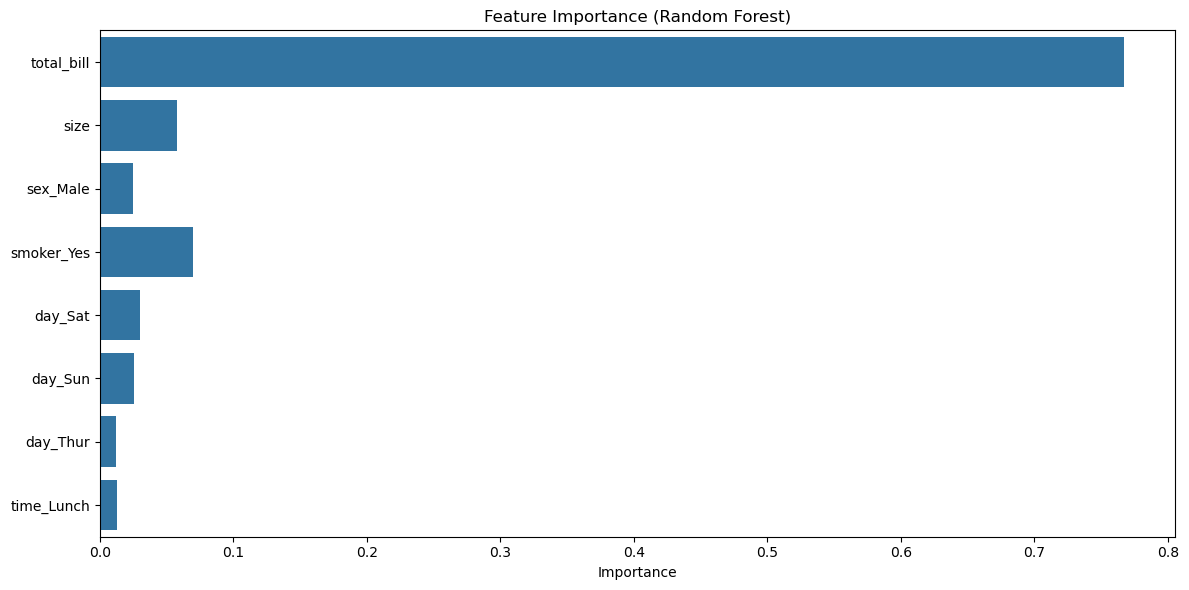

In [74]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
rf_pipeline.fit(X_train, y_train)

# Get feature names after preprocessing
feature_names = (numeric_features + 
                [f"{feat}_{val}" for feat, vals in 
                 zip(categorical_features, 
                     preprocessor.named_transformers_['cat'].categories_) 
                 for val in vals[1:]])

# Get feature importance
importance = rf_pipeline.named_steps['regressor'].feature_importances_

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=importance, y=feature_names)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## Residual Analysis using Linear Regressor

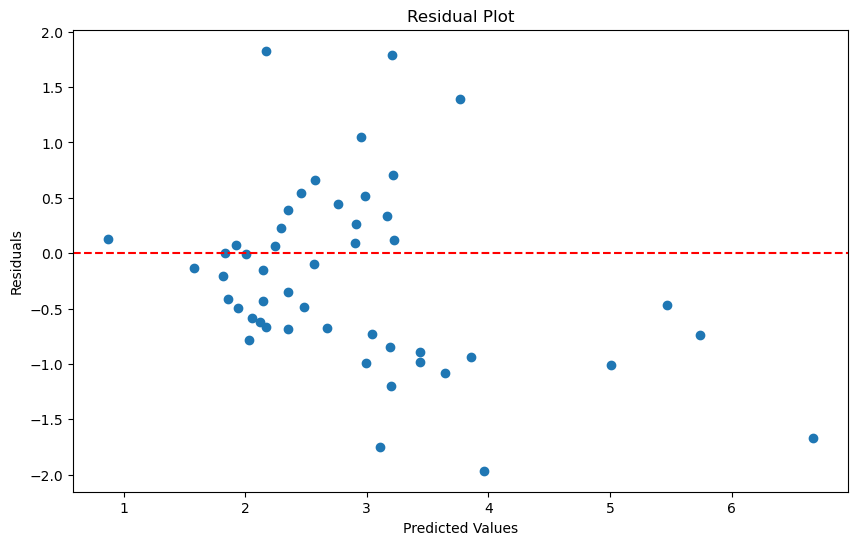

In [77]:
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test - y_pred)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


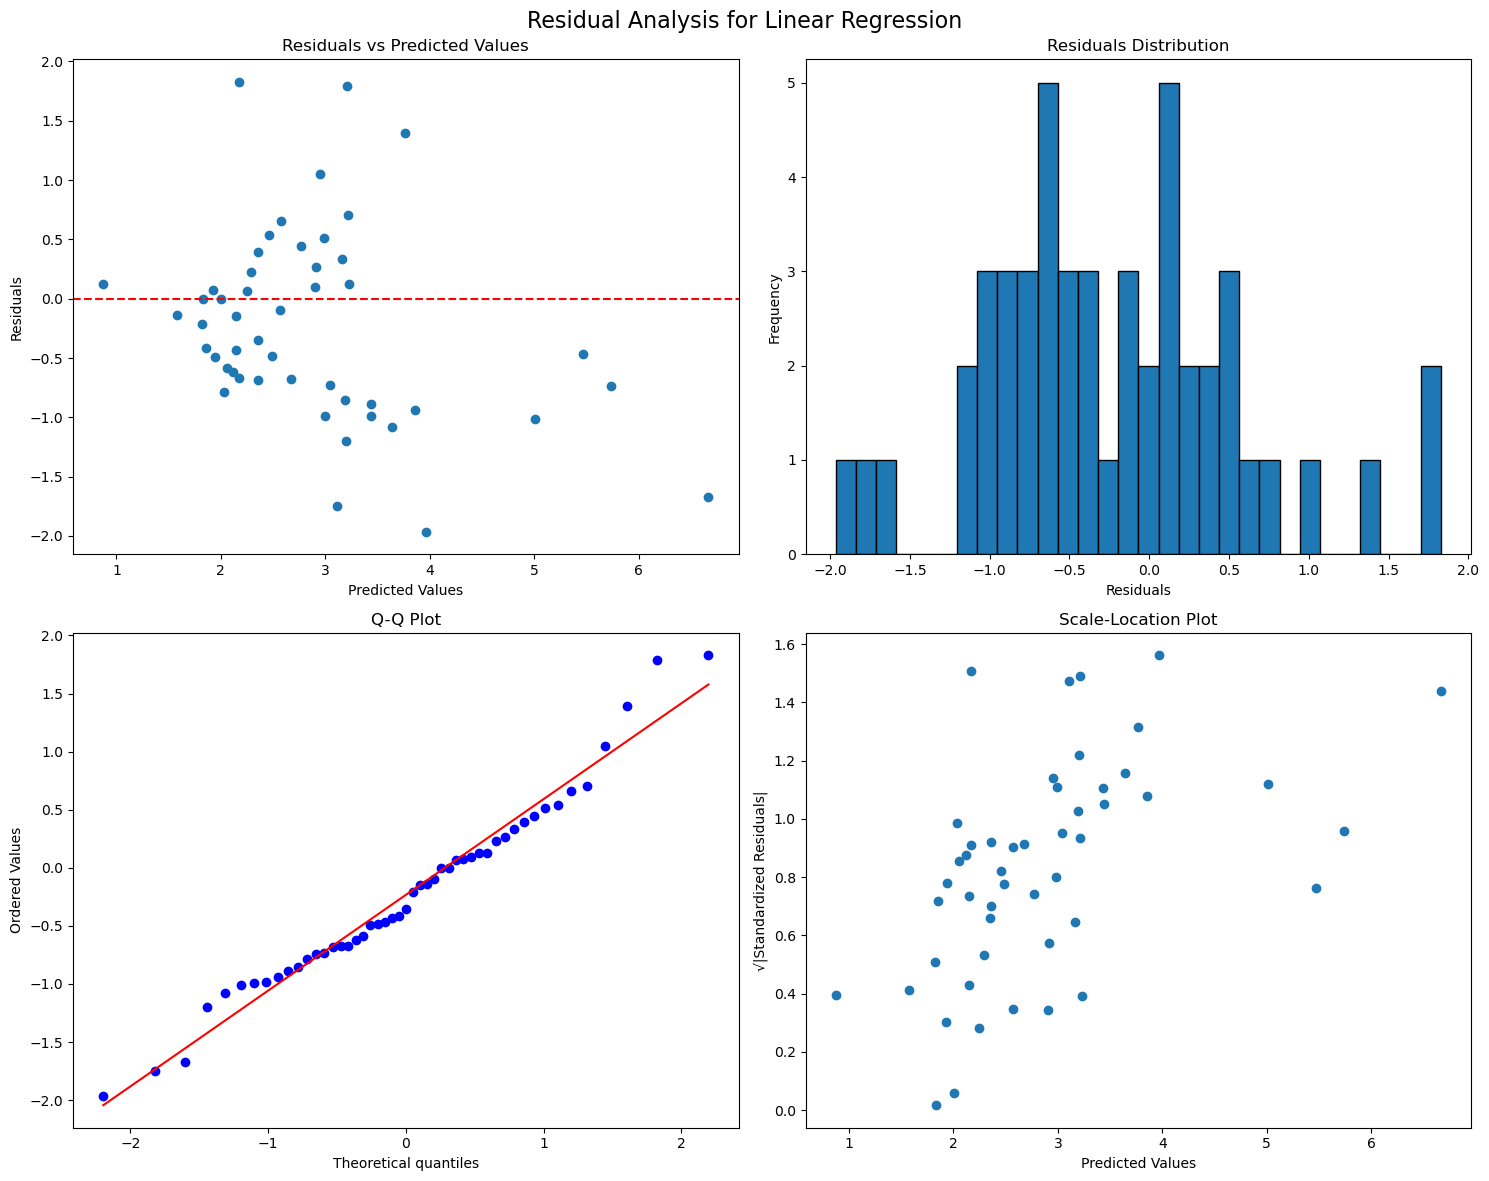


Linear Regression Results:
RMSE: 0.8387
R2 Score: 0.4373
Cross-validation R2 Scores: 0.4215 (+/- 0.2706)

Residual Statistics:
Mean of Residuals: -0.2330
Standard Deviation of Residuals: 0.8056
Skewness of Residuals: 0.4245
Kurtosis of Residuals: 0.3494


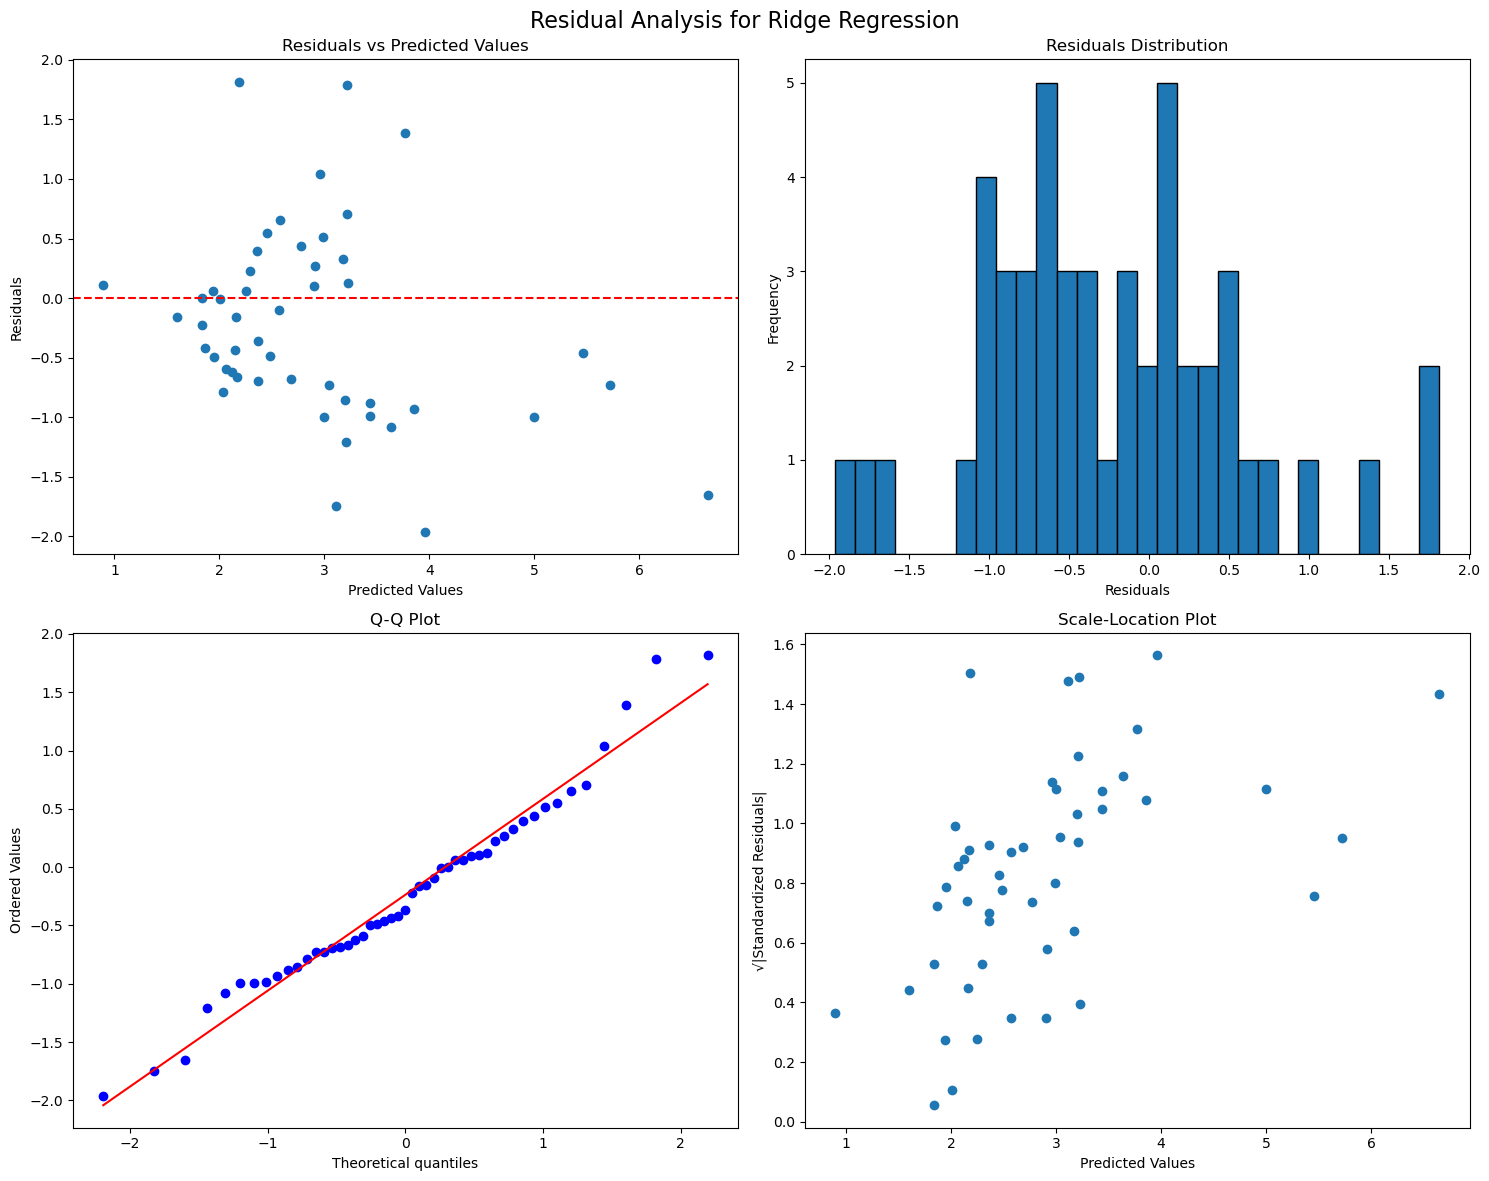


Ridge Regression Results:
RMSE: 0.8370
R2 Score: 0.4395
Cross-validation R2 Scores: 0.4231 (+/- 0.2668)

Residual Statistics:
Mean of Residuals: -0.2361
Standard Deviation of Residuals: 0.8031
Skewness of Residuals: 0.4312
Kurtosis of Residuals: 0.3501


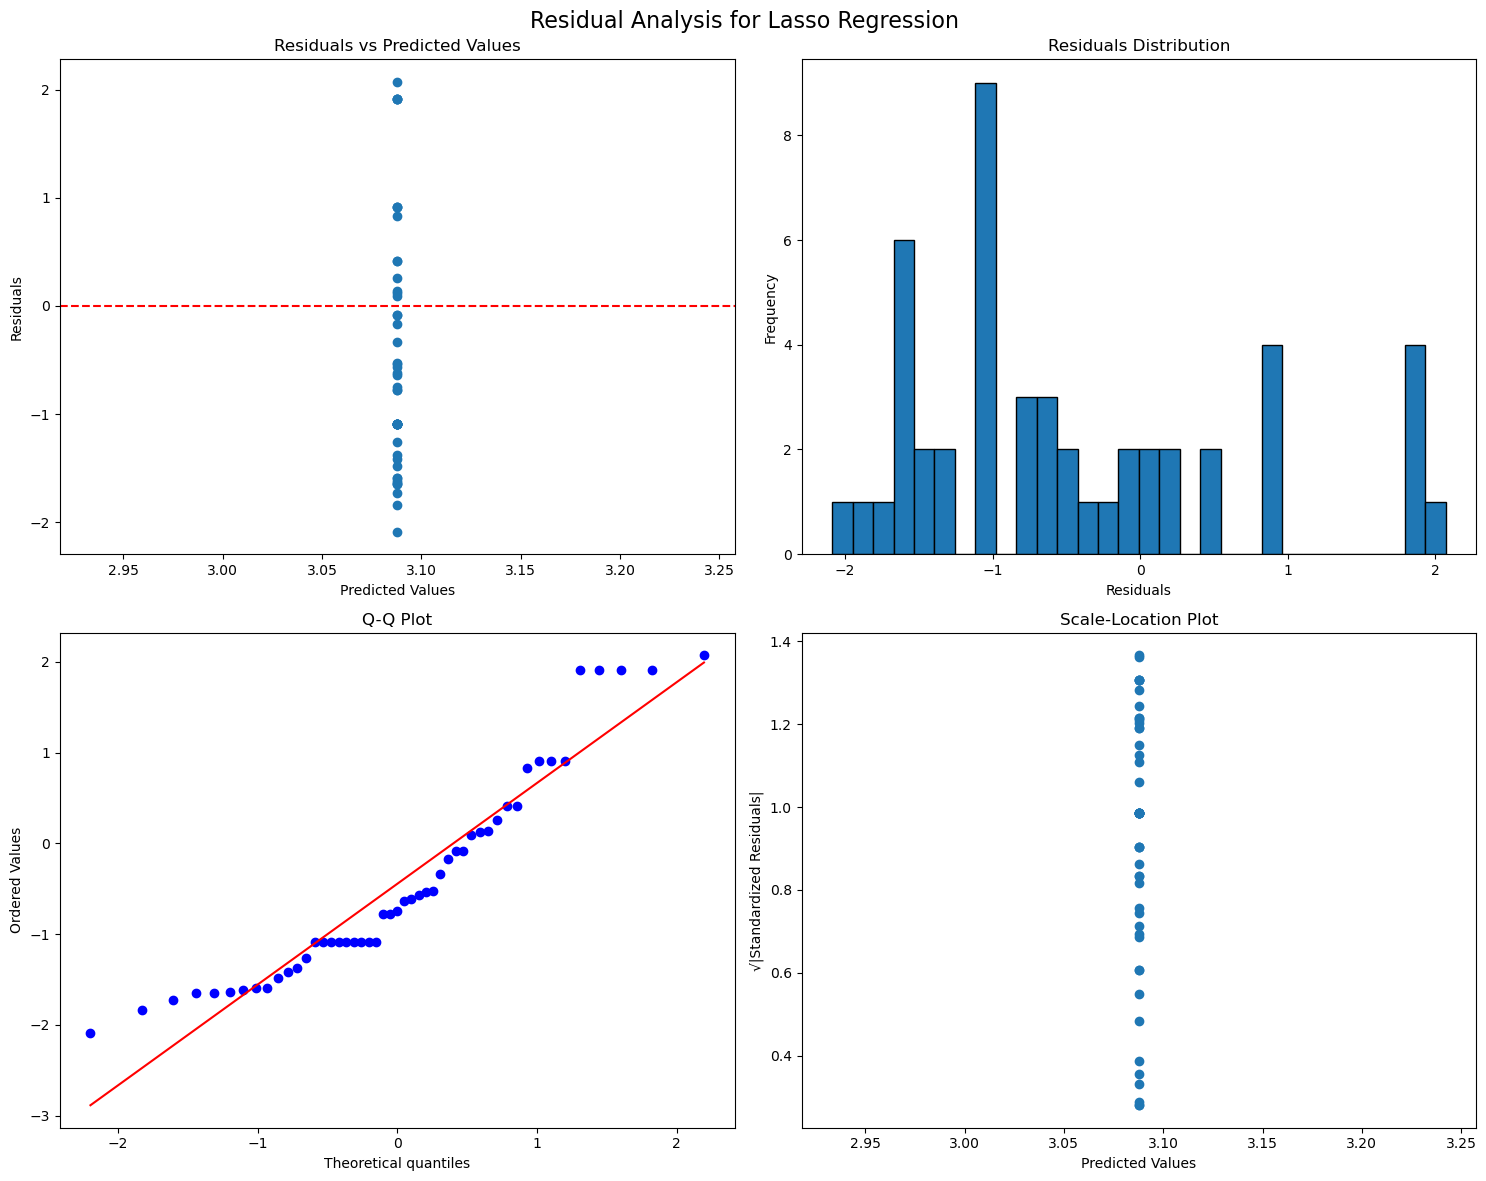


Lasso Regression Results:
RMSE: 1.2036
R2 Score: -0.1590
Cross-validation R2 Scores: -0.0231 (+/- 0.0334)

Residual Statistics:
Mean of Residuals: -0.4458
Standard Deviation of Residuals: 1.1180
Skewness of Residuals: 0.8095
Kurtosis of Residuals: -0.2780


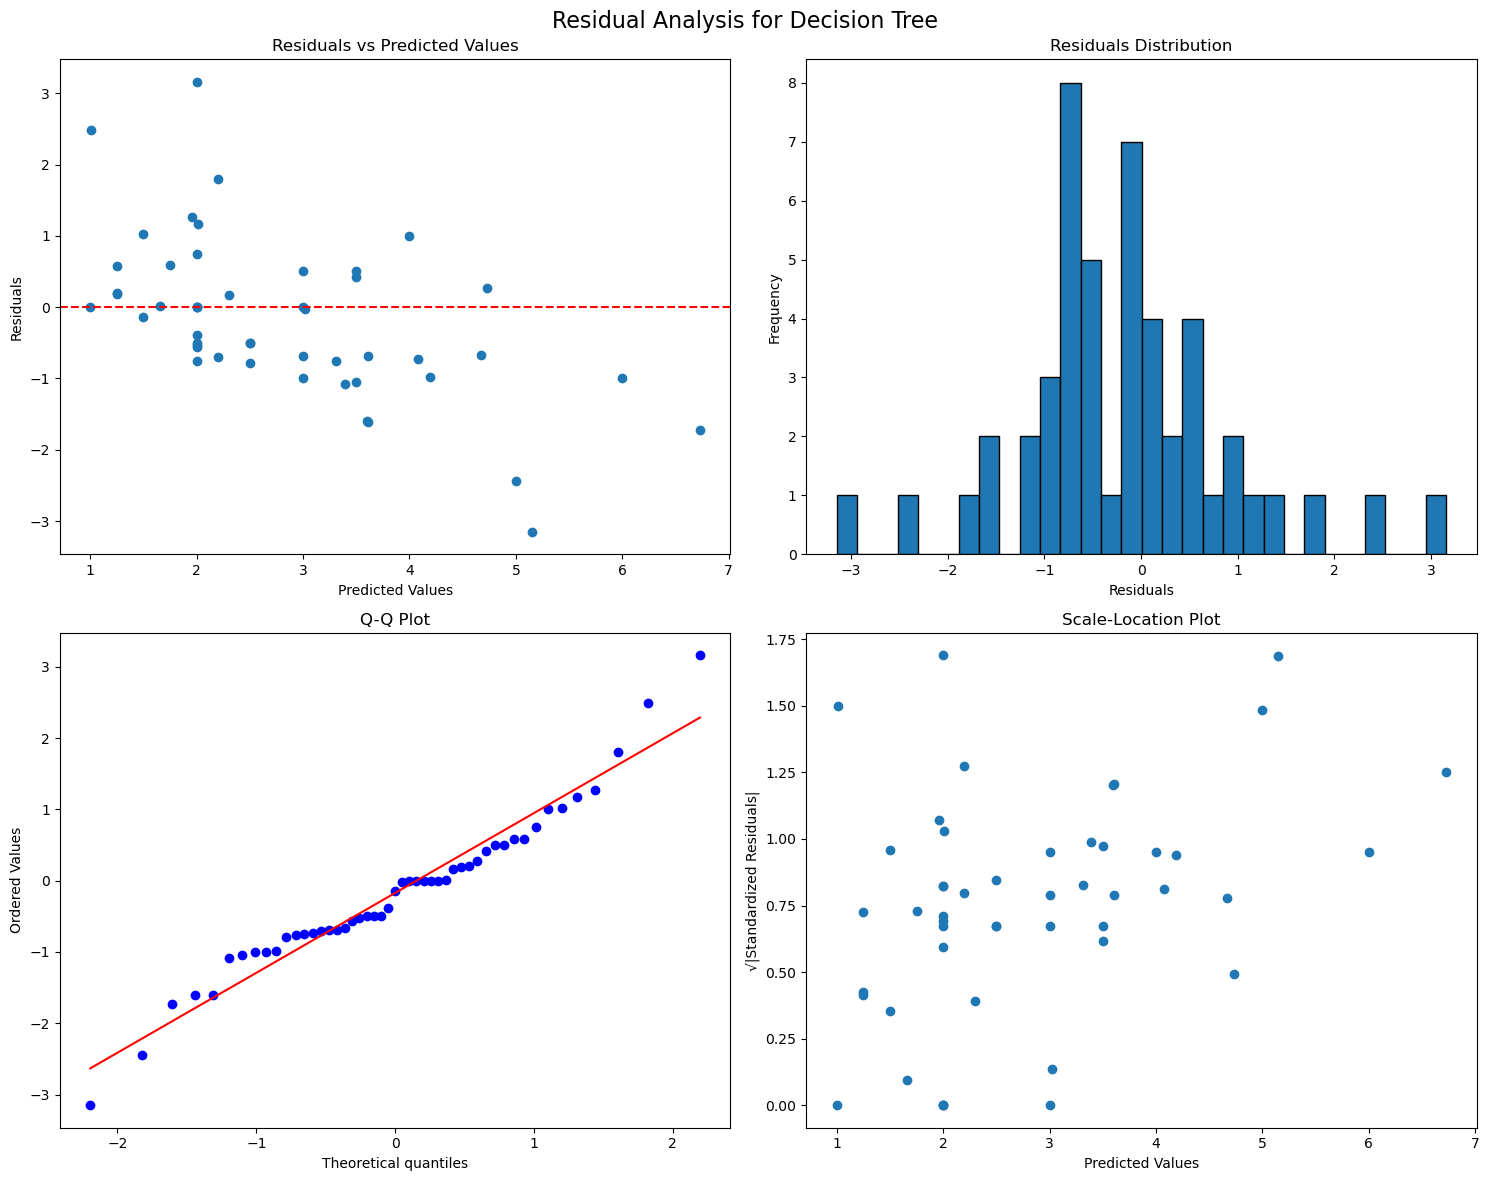


Decision Tree Results:
RMSE: 1.1204
R2 Score: -0.0042
Cross-validation R2 Scores: 0.1043 (+/- 0.3286)

Residual Statistics:
Mean of Residuals: -0.1729
Standard Deviation of Residuals: 1.1069
Skewness of Residuals: 0.3418
Kurtosis of Residuals: 1.4185


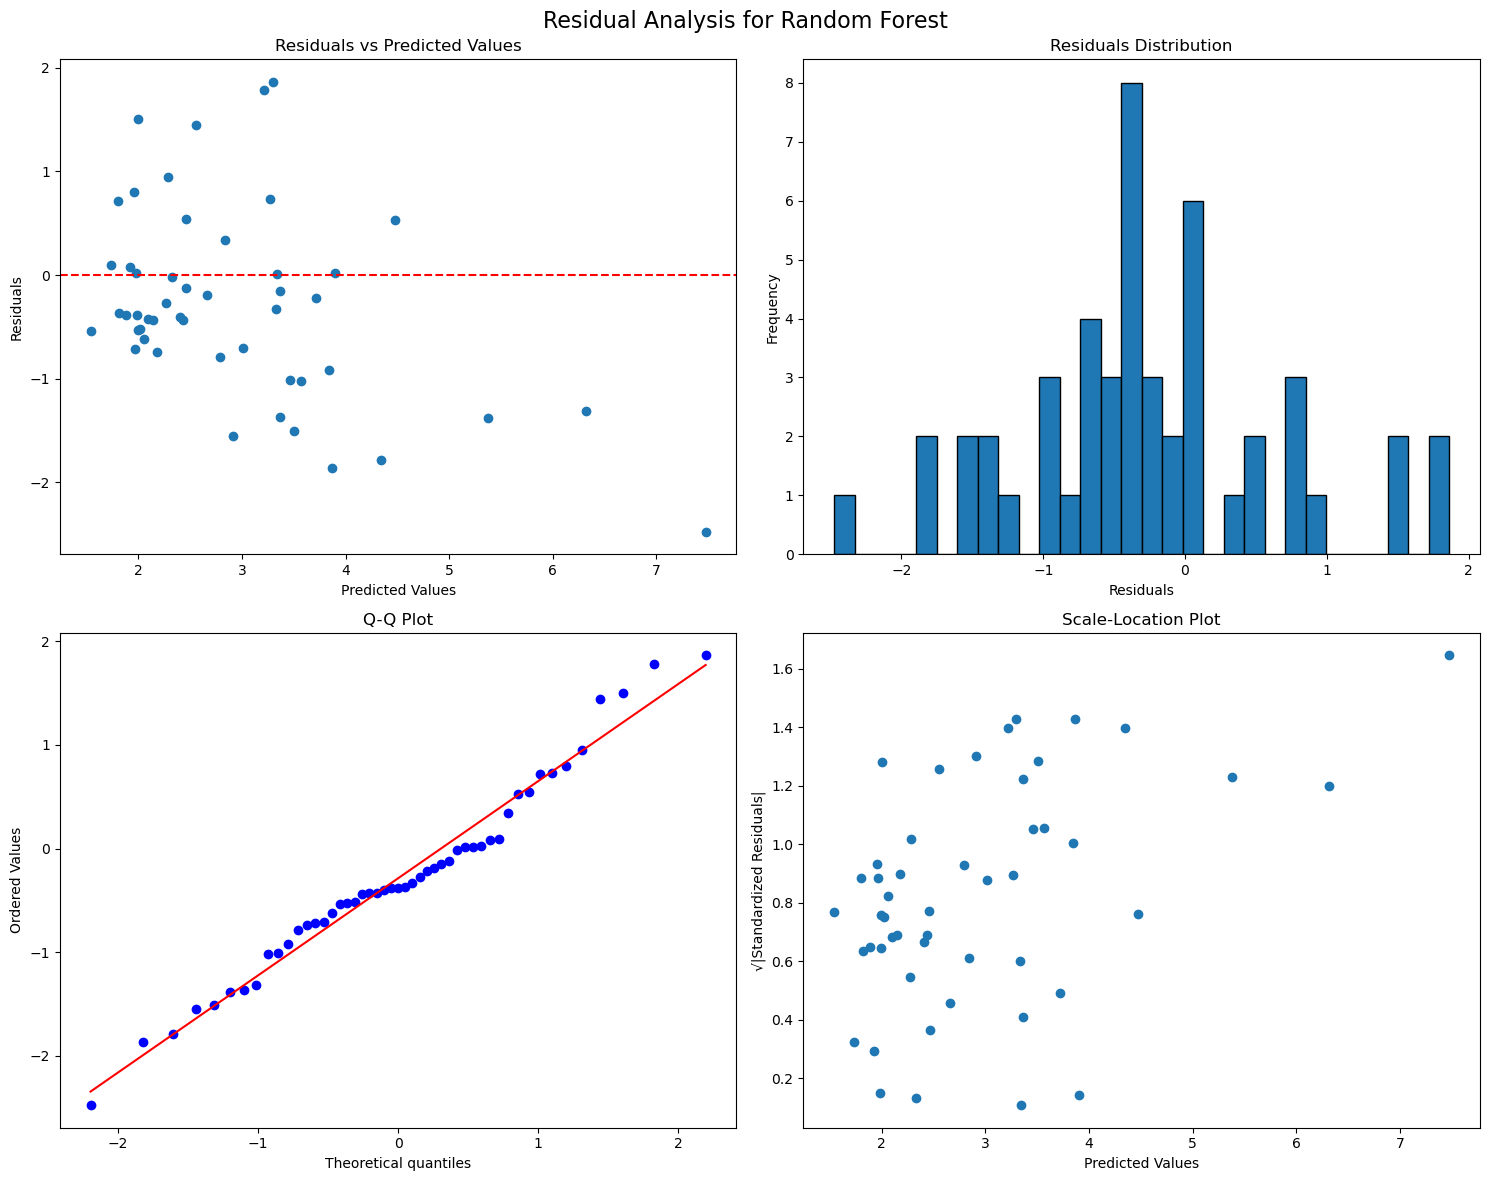


Random Forest Results:
RMSE: 0.9582
R2 Score: 0.2654
Cross-validation R2 Scores: 0.4015 (+/- 0.2425)

Residual Statistics:
Mean of Residuals: -0.2866
Standard Deviation of Residuals: 0.9144
Skewness of Residuals: 0.2616
Kurtosis of Residuals: 0.2019


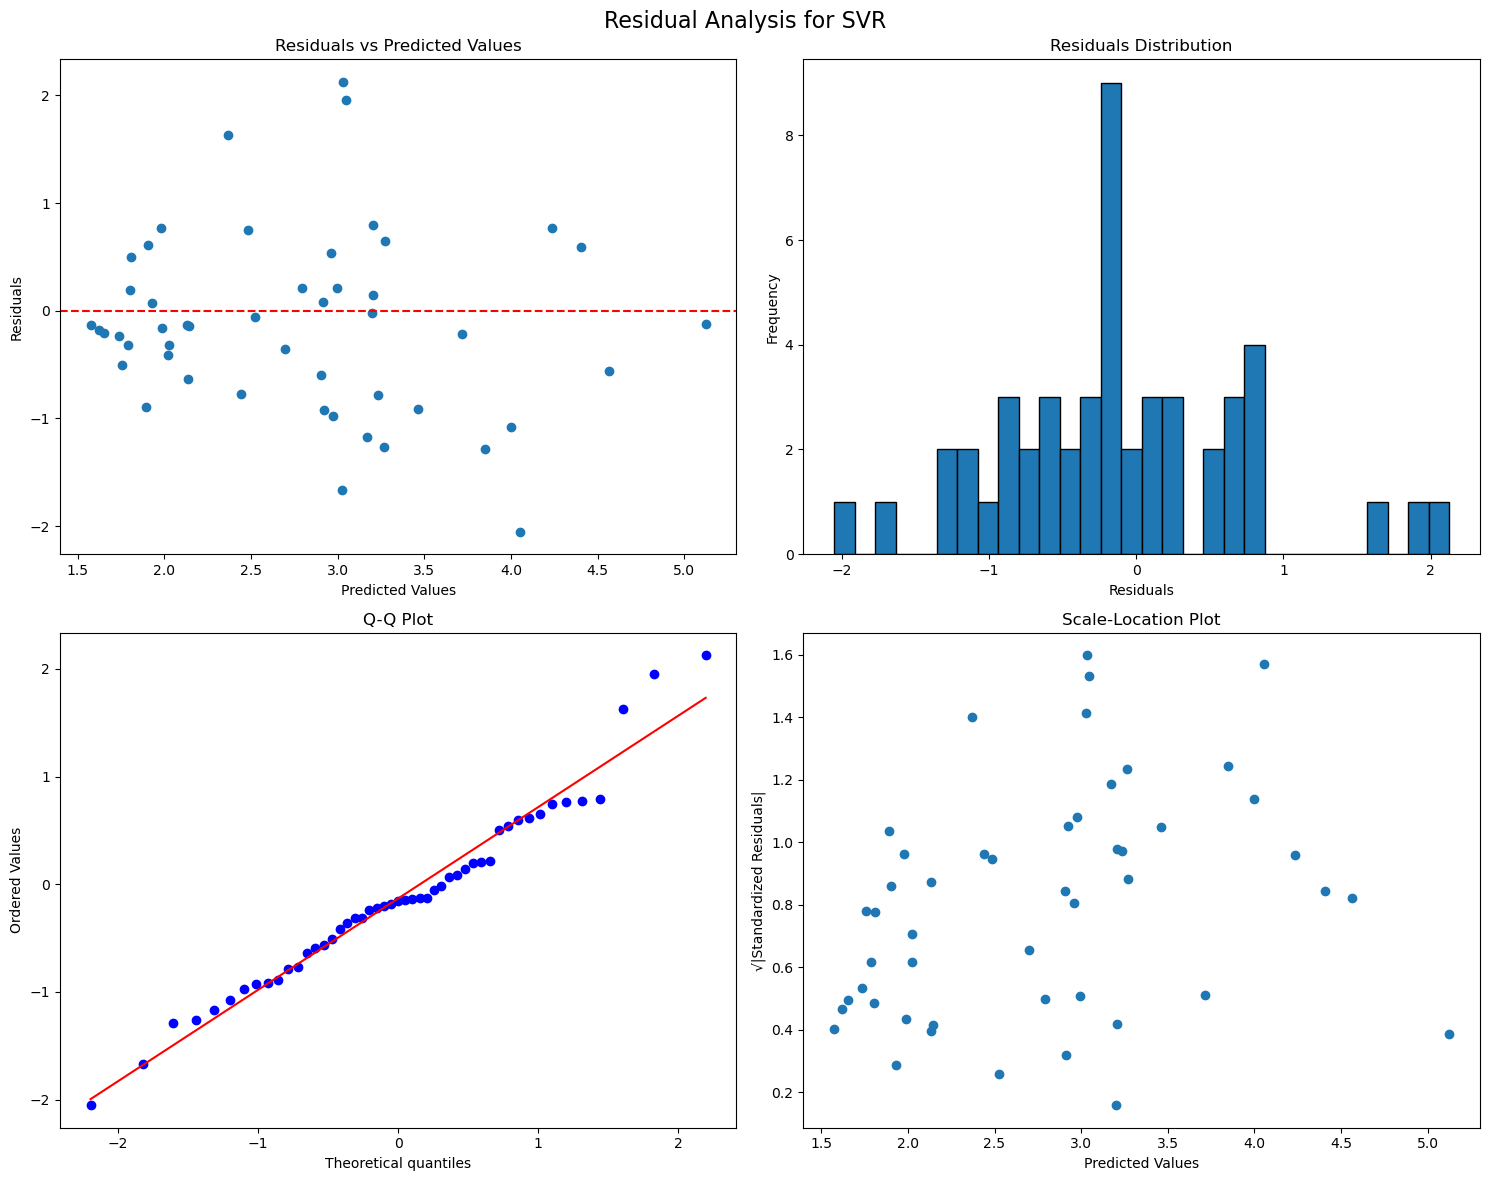


SVR Results:
RMSE: 0.8423
R2 Score: 0.4324
Cross-validation R2 Scores: 0.4049 (+/- 0.2603)

Residual Statistics:
Mean of Residuals: -0.1324
Standard Deviation of Residuals: 0.8319
Skewness of Residuals: 0.4401
Kurtosis of Residuals: 0.6388


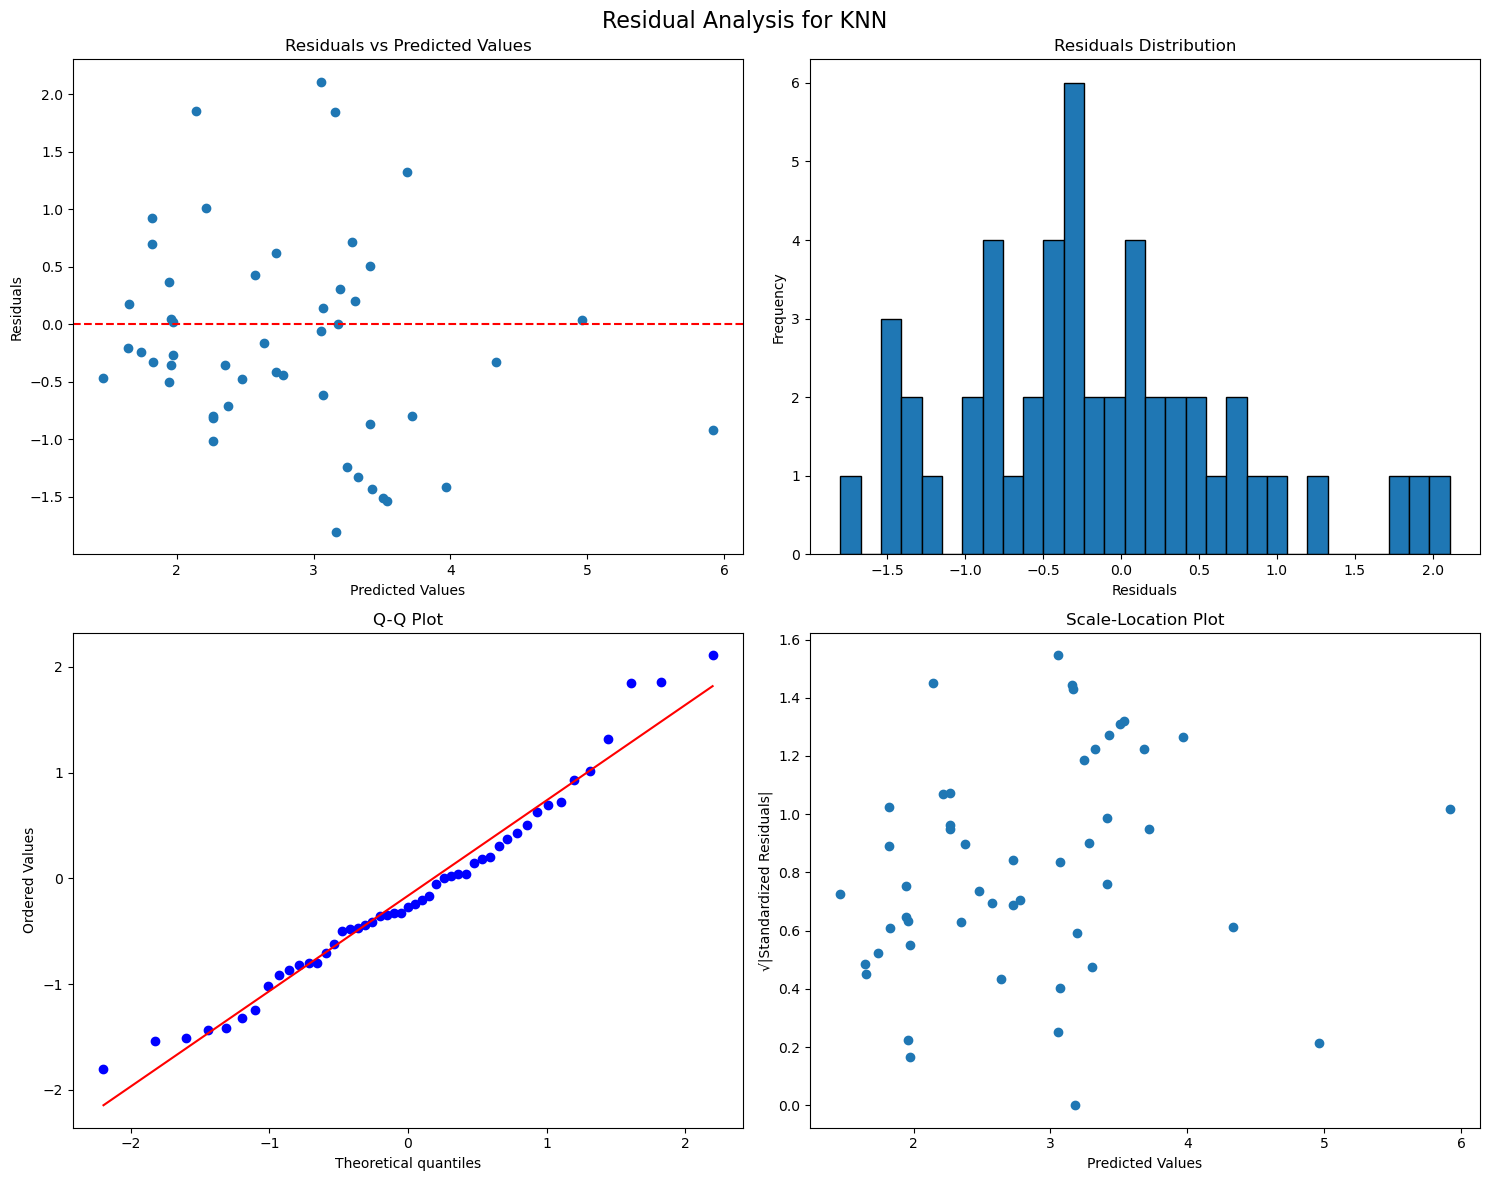


KNN Results:
RMSE: 0.8971
R2 Score: 0.3561
Cross-validation R2 Scores: 0.3378 (+/- 0.1663)

Residual Statistics:
Mean of Residuals: -0.1636
Standard Deviation of Residuals: 0.8821
Skewness of Residuals: 0.5410
Kurtosis of Residuals: 0.1569


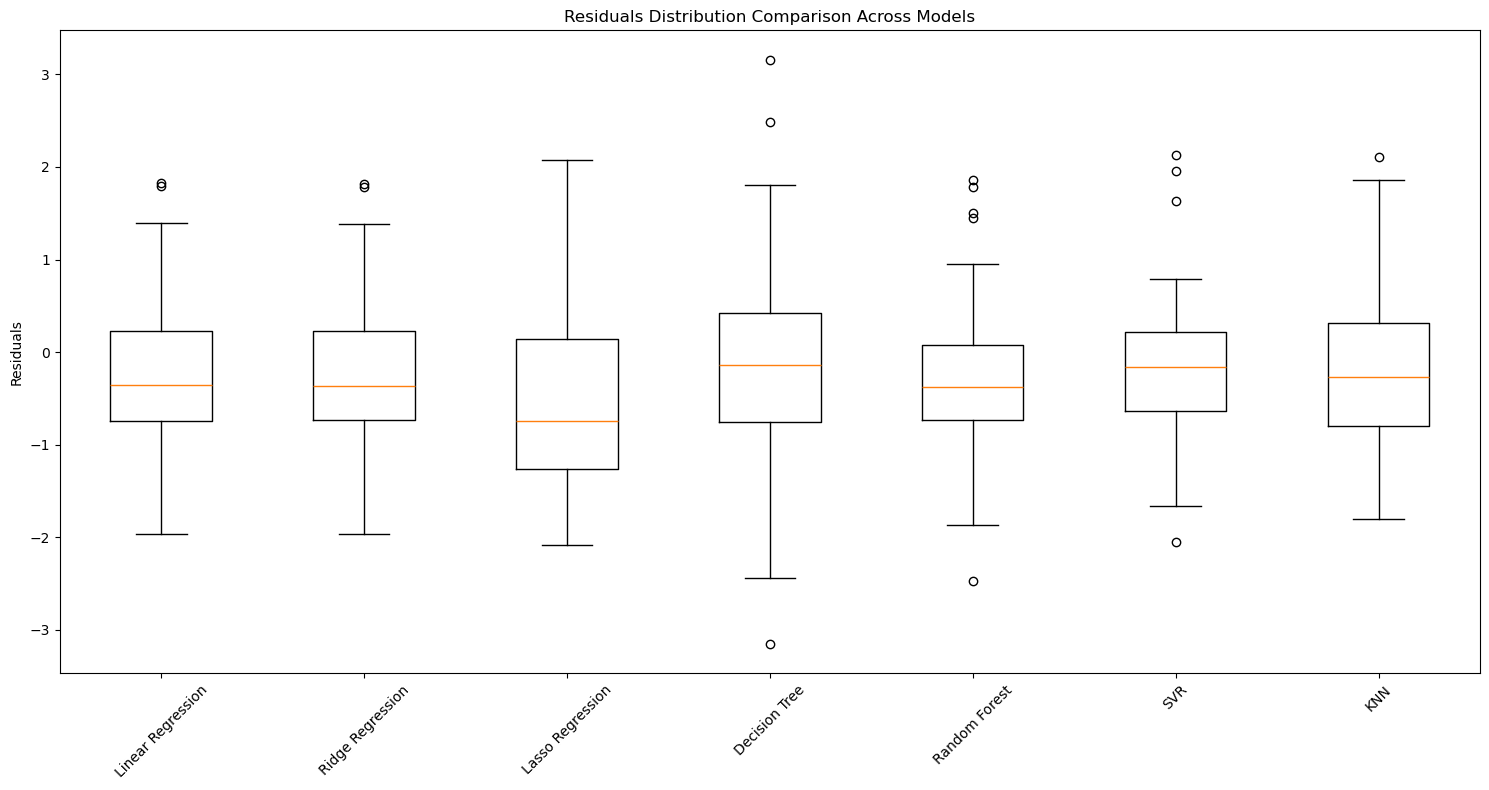


Residual Statistics Summary:
               Model    Mean  Std Dev  Skewness  Kurtosis
0  Linear Regression -0.2330   0.8056    0.4245    0.3494
1   Ridge Regression -0.2361   0.8031    0.4312    0.3501
2   Lasso Regression -0.4458   1.1180    0.8095   -0.2780
3      Decision Tree -0.1729   1.1069    0.3418    1.4185
4      Random Forest -0.2866   0.9144    0.2616    0.2019
5                SVR -0.1324   0.8319    0.4401    0.6388
6                KNN -0.1636   0.8821    0.5410    0.1569


In [85]:
def evaluate_model_with_residuals(model, name):
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Fit and predict
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    
    # Create residual plots
    residuals = y_test - y_pred
    
    # Create a figure with 4 subplots for different residual analyses
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Residual Analysis for {name}', fontsize=16)
    
    # 1. Residuals vs Predicted Values
    axes[0, 0].scatter(y_pred, residuals)
    axes[0, 0].axhline(y=0, color='r', linestyle='--')
    axes[0, 0].set_xlabel('Predicted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Predicted Values')
    
    # 2. Residuals Distribution
    axes[0, 1].hist(residuals, bins=30, edgecolor='black')
    axes[0, 1].set_xlabel('Residuals')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Residuals Distribution')
    
    # 3. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot')
    
    # 4. Scale-Location Plot
    standardized_residuals = residuals / np.std(residuals)
    axes[1, 1].scatter(y_pred, np.sqrt(np.abs(standardized_residuals)))
    axes[1, 1].set_xlabel('Predicted Values')
    axes[1, 1].set_ylabel('√|Standardized Residuals|')
    axes[1, 1].set_title('Scale-Location Plot')
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print(f"\n{name} Results:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Cross-validation R2 Scores: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Additional residual statistics
    print("\nResidual Statistics:")
    print(f"Mean of Residuals: {np.mean(residuals):.4f}")
    print(f"Standard Deviation of Residuals: {np.std(residuals):.4f}")
    print(f"Skewness of Residuals: {stats.skew(residuals):.4f}")
    print(f"Kurtosis of Residuals: {stats.kurtosis(residuals):.4f}")
    
    return pipeline, rmse, r2, residuals

# Create and evaluate models with residual analysis
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR(kernel='rbf'),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

results = {}
residuals_dict = {}

for name, model in models.items():
    pipeline, rmse, r2, residuals = evaluate_model_with_residuals(model, name)
    results[name] = {'RMSE': rmse, 'R2': r2}
    residuals_dict[name] = residuals

# Compare residuals across models
plt.figure(figsize=(15, 8))
plt.boxplot([residuals_dict[name] for name in models.keys()], labels=models.keys())
plt.xticks(rotation=45)
plt.title('Residuals Distribution Comparison Across Models')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

# Create a summary table of residual statistics
residual_stats = pd.DataFrame([
    {
        'Model': name,
        'Mean': np.mean(residuals),
        'Std Dev': np.std(residuals),
        'Skewness': stats.skew(residuals),
        'Kurtosis': stats.kurtosis(residuals)
    }
    for name, residuals in residuals_dict.items()
])

print("\nResidual Statistics Summary:")
print(residual_stats.round(4))

## Results:

- SVR performs better than most of the models out there
- Most important factor affecting tips is the total_bill and size of the party

## Management Recommendations:

1. Focus on total bill amount as it shows the strongest correlation with tip amount
2. Consider party size in service allocation as it significantly impacts tips
3. Pay attention to timing (dinner vs lunch) and day of the week patterns
4. Train staff to provide consistent service quality across different customer segments
5. Monitor and adapt strategies based on identified patterns in customer behavior
6. Should focus on giving better quality of service to Non Smokers as they tend to give more tips than Smokers
7. Pay attention and make special arrangements on weekends as people tend to give more tips on sundays and saturdays